In [2]:
import numpy as np 
import pandas as pd
import datetime as dt
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lgb
import shap
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold


%config InlineBackend.figure_format = 'retina'

### Task 1: GBDT

### Загрузка данных

In [104]:
train_types = {'msno' : 'category',
               'source_system_tab' : 'category',
               'source_screen_name' : 'category',
               'source_type' : 'category',
               'target' : np.uint8,
               'song_id' : 'category'}

test_types = {'msno' : 'category',
              'source_system_tab' : 'category',
              'source_screen_name' : 'category',
              'source_type' : 'category',
              'song_id' : 'category'}

songs_types = {'genre_ids': 'category',
               'language' : 'category',
               'artist_name' : 'category',
               'composer' : 'category',
               'lyricist' : 'category',
               'song_id' : 'category'}

members_types = {'city' : 'category',
                 'bd' : np.uint8,
                 'gender' : 'category',
                 'registered_via' : 'category'}

train = pd.read_csv('train.csv', dtype=train_types)
test = pd.read_csv('test.csv', dtype=test_types)
songs = pd.read_csv('songs.csv', dtype=songs_types)
members = pd.read_csv('members.csv',dtype=members_types, parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')

### Обработка данных

In [105]:
def print_nan(df):
    for col in df.columns:
        print(f"{100*df[col].isna().sum()/df[col].shape[0]} % Nan of {col}")
        
def merge(train, test, df, name):
    train = train.merge(df, on=name, how='left')
    test = test.merge(df, on=name, how='left')
    return train, test

In [106]:
#датасет members

In [107]:
print_nan(members)

0.0 % Nan of msno
0.0 % Nan of city
0.0 % Nan of bd
57.849606138999505 % Nan of gender
0.0 % Nan of registered_via
0.0 % Nan of registration_init_time
0.0 % Nan of expiration_date


In [108]:
def year_month_day(col):
    return col.dt.year, col.dt.month, col.dt.day

#фича пол содержит больше половины nan, заменим их на <unknown> gender
members['gender'] = members['gender'].astype('str').replace('nan', 'unknown').astype('category')
#извлечем год, месяц, день регистрации и конца пользования
members['registration_year'], members['registration_month'], members['registration_day']  = year_month_day(members.registration_init_time)
members['expiration_year'], members['expiration_month'], members['expiration_day'] = year_month_day(members.expiration_date)

#добавим данные к трейну и тесту 
members = members.drop(['registration_init_time', 'expiration_date'], axis=1)
train, test = merge(train, test, members, "msno")
del members

In [109]:
#датасет songs

In [110]:
print_nan(songs)

0.0 % Nan of song_id
0.0 % Nan of song_length
4.0985576923076925 % Nan of genre_ids
0.0 % Nan of artist_name
46.65525710702341 % Nan of composer
84.71240942028986 % Nan of lyricist
4.35479375696767e-05 % Nan of language


In [111]:
#удалим composer и lyricist которые содержат слишком много nan values
songs = songs.drop(['composer', 'lyricist'], axis=1)
train, test = merge(train, test, songs, "song_id")
del songs 

In [112]:
#датасет songs

In [113]:
print_nan(songs_extra)

0.0 % Nan of song_id
8.710911418306241e-05 % Nan of name
5.9472876617344035 % Nan of isrc


In [114]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        year = int(isrc[5:7])
        if year > 17:
            return 1900 + year
        else:
            return 2000 + year
    else:
        return np.nan
    
#извлечем год и страну песен
songs_extra['country'] = songs_extra['isrc'].apply(lambda x: x[:2] if type(x) == str else np.nan)
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)
train, test = merge(train, test, songs_extra, "song_id")
del songs_extra

In [115]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [116]:
#nan для song_length заменим на среднее значение на трейне и тесте
train['song_length'].fillna((train['song_length'].mean()), inplace=True)
test['song_length'].fillna((train['song_length'].mean()), inplace=True)

### Фичи счетчики

In [117]:
#введем фичи: сколько пользователь слушал песен, популярность данного жанра по всем юзерам, популярность артиста
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
dict_genre_pop = {k:v for k,v in pd.concat([train['genre_ids'] , test['genre_ids']] , axis = 0).value_counts().iteritems()}
dict_artist_pop = {k:v for k,v in pd.concat([train['artist_name'] , test['artist_name']] , axis = 0).value_counts().iteritems()}

def find_in_dict(x, dict_):
    try:
        return dict_[x]
    except KeyError:
        return 0

train["index"]  = train.index
train['user_activity_msno'] = train['msno'].apply(lambda x: find_in_dict(x, dict_user_activity))
test['user_activity_msno'] = test['msno'].apply(lambda x: find_in_dict(x, dict_user_activity))

train['genres_pop'] = train['genre_ids'].apply(lambda x: find_in_dict(x, dict_genre_pop))
test['genres_pop'] = test['genre_ids'].apply(lambda x: find_in_dict(x, dict_genre_pop))

train['artist_pop'] = train['artist_name'].apply(lambda x: find_in_dict(x, dict_artist_pop))
test['artist_pop'] = test['artist_name'].apply(lambda x: find_in_dict(x, dict_artist_pop))

#введем фичи: какая песенка у пользователя по счету из прослушанных такого жанра и такого артиста сгладим логарифмом 
train['msno_genre'] = train['msno'].astype(str) + "+" + train['genre_ids'].astype(str)
train['msno_artist'] = train['msno'].astype(str) + "+" + train['artist_name'].astype(str)
train['genre_hist'] = train.groupby('msno_genre').index.rank(method='min').astype(int)/np.log(train["index"]+2)
train['artists_hist'] = train.groupby('msno_artist').index.rank(method='min').astype(int)/np.log(train["index"]+2)

### Подбор параметров

In [135]:
X = train.drop(['target','msno', 'song_id', 'msno_artist', 'msno_genre', 'index'], axis=1)
y = train['target']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

lgbtrain = lgb.Dataset(X_train, y_train)
lgbval = lgb.Dataset(X_test, y_test)

def objective(trial):

    
    param = {
        'num_leaves': 256,
        'objective': 'binary',
        "metric":'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.2, 0.3, step = 0.01),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'verbosity': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10, step = 0.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10, step = 0.5),
        "seed": 0,
        "nthread": -1     
    }
    evals={}
    gbm = lgb.train(param, 
                    train_set=lgbtrain, 
                    num_boost_round=50, 
                    valid_sets = [lgbtrain, lgbval], 
                    verbose_eval = 25,
                    evals_result=evals)
    auc = np.array(evals['valid_1']['auc'])
    return np.max(auc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2020-11-02 23:10:55,611] A new study created in memory with name: no-name-da50bda8-4c37-46b1-ae95-6430c09660a5


[25]	training's auc: 0.723879	valid_1's auc: 0.719329
[50]	training's auc: 0.732941	valid_1's auc: 0.726311


[I 2020-11-02 23:12:19,116] Trial 0 finished with value: 0.7263113554047584 and parameters: {'learning_rate': 0.26, 'max_depth': 7, 'lambda_l1': 3.5, 'lambda_l2': 8.0}. Best is trial 0 with value: 0.7263113554047584.


[25]	training's auc: 0.733799	valid_1's auc: 0.726526
[50]	training's auc: 0.743192	valid_1's auc: 0.733012


[I 2020-11-02 23:13:32,802] Trial 1 finished with value: 0.7330122930001638 and parameters: {'learning_rate': 0.29000000000000004, 'max_depth': 8, 'lambda_l1': 3.5, 'lambda_l2': 6.5}. Best is trial 1 with value: 0.7330122930001638.


[25]	training's auc: 0.714872	valid_1's auc: 0.712473
[50]	training's auc: 0.723271	valid_1's auc: 0.719489


[I 2020-11-02 23:14:51,336] Trial 2 finished with value: 0.7194886132116877 and parameters: {'learning_rate': 0.2, 'max_depth': 6, 'lambda_l1': 4.0, 'lambda_l2': 7.5}. Best is trial 1 with value: 0.7330122930001638.


[25]	training's auc: 0.743588	valid_1's auc: 0.732852
[50]	training's auc: 0.756616	valid_1's auc: 0.74119


[I 2020-11-02 23:16:23,022] Trial 3 finished with value: 0.7411900321094568 and parameters: {'learning_rate': 0.24000000000000002, 'max_depth': 10, 'lambda_l1': 1.5, 'lambda_l2': 7.5}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.724895	valid_1's auc: 0.720146
[50]	training's auc: 0.732744	valid_1's auc: 0.725937


[I 2020-11-02 23:17:46,017] Trial 4 finished with value: 0.725937193869723 and parameters: {'learning_rate': 0.26, 'max_depth': 7, 'lambda_l1': 1.0, 'lambda_l2': 1.0}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.708804	valid_1's auc: 0.70749
[50]	training's auc: 0.715896	valid_1's auc: 0.713753


[I 2020-11-02 23:18:54,076] Trial 5 finished with value: 0.7137531881700545 and parameters: {'learning_rate': 0.2, 'max_depth': 5, 'lambda_l1': 9.0, 'lambda_l2': 6.5}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.7226	valid_1's auc: 0.718593
[50]	training's auc: 0.732288	valid_1's auc: 0.725925


[I 2020-11-02 23:20:14,210] Trial 6 finished with value: 0.7259245275462537 and parameters: {'learning_rate': 0.21000000000000002, 'max_depth': 7, 'lambda_l1': 2.0, 'lambda_l2': 5.5}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.731695	valid_1's auc: 0.724988
[50]	training's auc: 0.741115	valid_1's auc: 0.731759


[I 2020-11-02 23:21:30,848] Trial 7 finished with value: 0.7317590503708766 and parameters: {'learning_rate': 0.29000000000000004, 'max_depth': 8, 'lambda_l1': 6.0, 'lambda_l2': 5.0}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.718216	valid_1's auc: 0.715316
[50]	training's auc: 0.725726	valid_1's auc: 0.721211


[I 2020-11-02 23:22:39,275] Trial 8 finished with value: 0.7212105016041945 and parameters: {'learning_rate': 0.26, 'max_depth': 6, 'lambda_l1': 0.5, 'lambda_l2': 0.0}. Best is trial 3 with value: 0.7411900321094568.


[25]	training's auc: 0.744013	valid_1's auc: 0.733116
[50]	training's auc: 0.759174	valid_1's auc: 0.742952


[I 2020-11-02 23:24:40,205] Trial 9 finished with value: 0.7429523705656211 and parameters: {'learning_rate': 0.27, 'max_depth': 10, 'lambda_l1': 2.0, 'lambda_l2': 2.5}. Best is trial 9 with value: 0.7429523705656211.


In [161]:
def training_lgb(data):
    X_train, y_train, X_test, y_test = data 
    lgbtrain = lgb.Dataset(X_train, y_train)
    lgbval = lgb.Dataset(X_test, y_test)


    params = {'objective': 'binary',
              'learning_rate': 0.27,
              'metric': 'auc',
              'max_depth': 10, 
              'num_leaves': 256, 
              'lambda_l1': 2.0,
              'lambda_l2': 2.5}

    gbm = lgb.train(params, 
                      train_set=lgbtrain, 
                      num_boost_round=100, 
                      
                      verbose_eval=25,
                      valid_sets=[lgbtrain, lgbval],)
    y_pred = gbm.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    return gbm, auc

In [188]:
def k_fold_training(X, y, k=5):
    aucs = []
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    """
    по идее так должно норм по юзерам разбивать 
    """
    
    for i, (train_ind, test_ind) in enumerate(kf.split(X, train['msno'])):
        print(f"Folder {i+1}:")
    
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]
        
        X_train, X_val, y_train, y_tval = train_test_split(X_train, y_train, test_size=0.2, random_state=10, stratify=y_train)
        

#         model, score = training_lgb((X_train, y_train, X_test, y_test))
#         stats.append((score, model, X_test))

        lgbtrain = lgb.Dataset(X_train, y_train)
        lgbval = lgb.Dataset(X_val, y_tval)


        params = {'objective': 'binary',
                  'learning_rate': 0.27,
                  'metric': 'auc',
                  'max_depth': 10, 
                  'num_leaves': 256, 
                  'lambda_l1': 2.0,
                  'lambda_l2': 2.5}

        gbm = lgb.train(params, 
                          train_set=lgbtrain, 
                          num_boost_round=100, 

                          verbose_eval=25,
                          valid_sets=[lgbtrain, lgbval],)
        y_pred = gbm.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        print(auc)
        aucs.append(auc)
   
    print(f'Mean AUC_ROC: {np.mean(aucs):.3f} with {k} folds')

In [160]:
def split_training(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    model, score = training_lgb((X_train, y_train, X_test, y_test))
    return model

def feture_imps(model):
    df_feat = pd.DataFrame(data=model.feature_importance(), index=model.feature_name(), columns=['importance'])
    df_feat = df_feat.sort_values(by='importance', ascending=False)
    df_feat['feat'] = df_feat.index
    return df_feat

In [163]:
model = split_training(X, y)

[25]	training's auc: 0.741336	valid_1's auc: 0.731534
[50]	training's auc: 0.754445	valid_1's auc: 0.740408
[75]	training's auc: 0.763384	valid_1's auc: 0.745765
[100]	training's auc: 0.769511	valid_1's auc: 0.749081


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### SHAP values

In [165]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

/Library/miniconda3/lib/python3.8/site-packages/shap/explainers/_tree.py:292: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



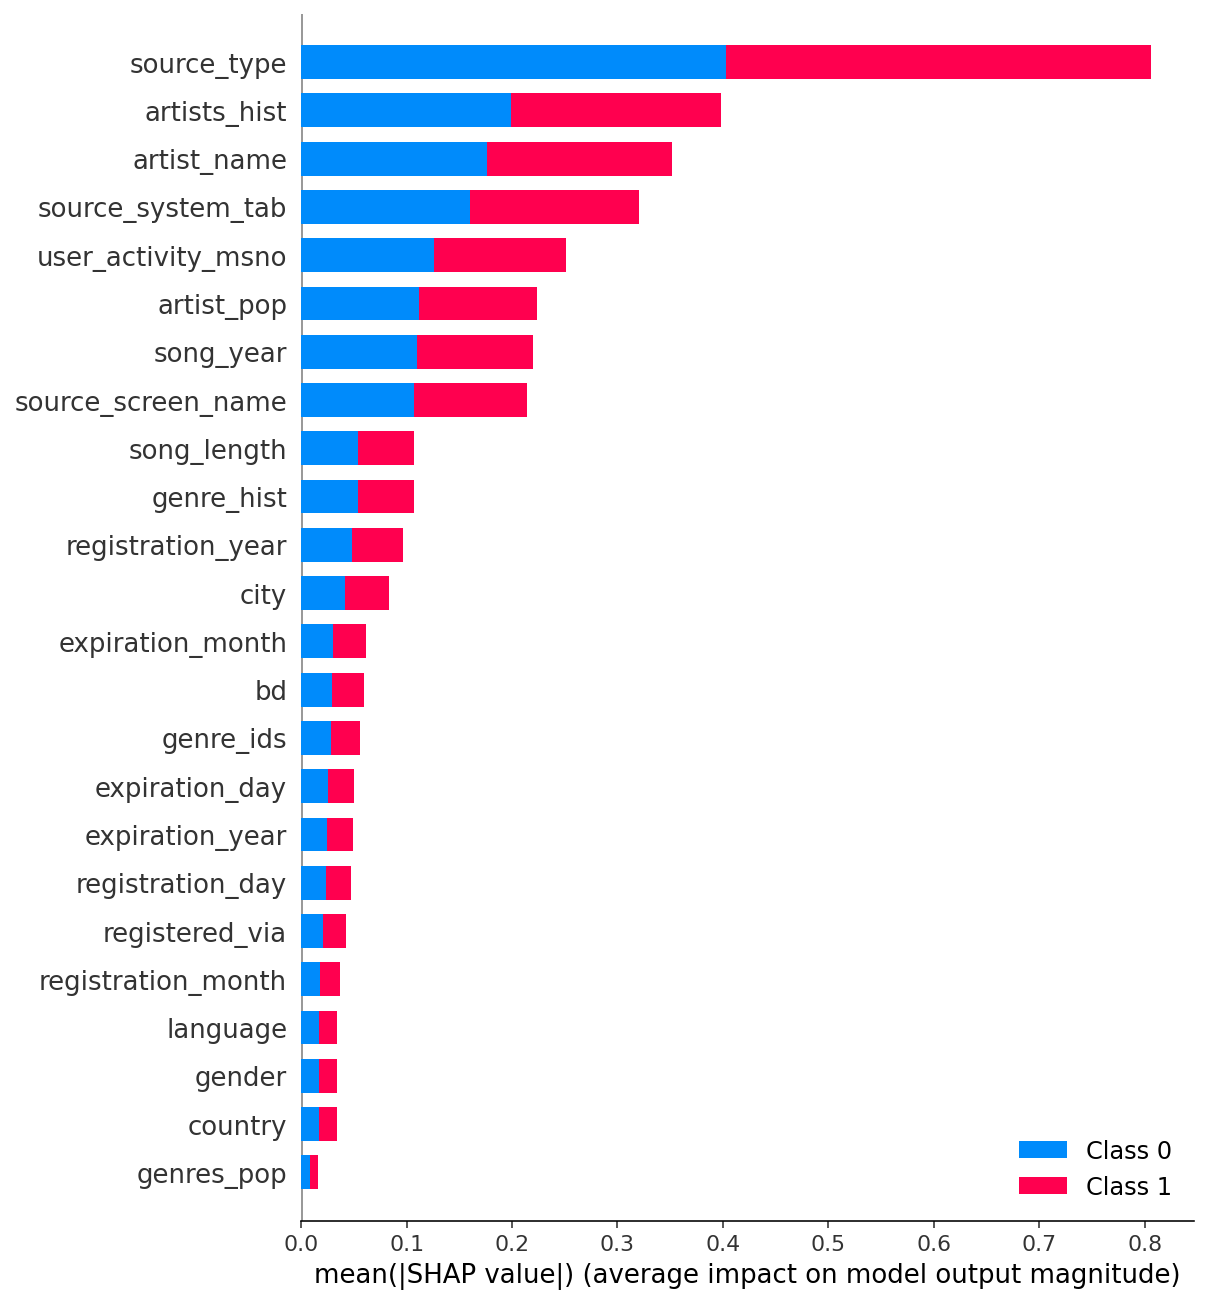

In [170]:
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

In [171]:
#Удалим наименне значимые фичи
X_new = X.drop(['country','genres_pop', 'country', 'gender', 'language'], axis=1)

In [172]:
model_new = split_training(X_new, y)

[25]	training's auc: 0.742423	valid_1's auc: 0.732716
[50]	training's auc: 0.755066	valid_1's auc: 0.740843
[75]	training's auc: 0.76463	valid_1's auc: 0.746506
[100]	training's auc: 0.771657	valid_1's auc: 0.750276


In [ ]:
#качество немного улучшилось

### Кросс валидация

In [ ]:
#разбивает т о чтобы в фолды попадало равномерно одного и того же юзера

In [189]:
k_fold_training(X_new, y)

/Library/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Folder 1:
[25]	training's auc: 0.741776	valid_1's auc: 0.729724
[50]	training's auc: 0.75521	valid_1's auc: 0.738241
[75]	training's auc: 0.763613	valid_1's auc: 0.742834
[100]	training's auc: 0.770947	valid_1's auc: 0.746263
0.7467767552355191
Folder 2:
[25]	training's auc: 0.743748	valid_1's auc: 0.731018
[50]	training's auc: 0.756006	valid_1's auc: 0.738161
[75]	training's auc: 0.765712	valid_1's auc: 0.743566
[100]	training's auc: 0.773633	valid_1's auc: 0.747744
0.7477137012632505
Folder 3:
[25]	training's auc: 0.742385	valid_1's auc: 0.730985
[50]	training's auc: 0.754654	valid_1's auc: 0.73861
[75]	training's auc: 0.764511	valid_1's auc: 0.743999
[100]	training's auc: 0.772389	valid_1's auc: 0.747955
0.7478111214413679
Folder 4:
[25]	training's auc: 0.743015	valid_1's auc: 0.730928
[50]	training's auc: 0.756742	valid_1's auc: 0.73937
[75]	training's auc: 0.765523	valid_1's auc: 0.744218
[100]	training's auc: 0.77383	valid_1's auc: 0.748539
0.7487753924385516
Folder 5:
[25]	train